# Apply CNN Classifier to DESI Spectra and visualize results with gradCAM

Mini-SV2 tiles from February-March 2020:
- https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

See also the DESI tile picker with (limited) SV0 tiles from March 2020:
- https://desi.lbl.gov/svn/data/tiles/trunk/
- https://desi.lbl.gov/svn/data/tiles/trunk/SV0.html

In [2]:
import sys
sys.path.append('/global/homes/p/palmese/desi/timedomain/desitrip/py/') #Note:change this path as needed!
sys.path.append('/global/homes/p/palmese/desi/timedomain/timedomain/')

from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra
from desispec.coaddition import coadd_cameras

from desitarget.cmx.cmx_targetmask import cmx_mask

from desitrip.preproc import rebin_flux, rescale_flux
from desitrip.deltamag import delta_mag

from astropy.io import fits
from astropy.table import Table, vstack, hstack

from glob import glob
from datetime import date

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras

In [3]:
mpl.rc('font', size=14)

In [4]:
# Set up BGS target bit selection.
cmx_bgs_bits = '|'.join([_ for _ in cmx_mask.names() if 'BGS' in _])

## Select a Date & Tile from matches files

In [5]:

matches_filename='matches_DECam.npy'

file_arr=np.load('matches_DECam.npy', allow_pickle=True)

obsdates = file_arr[:,0]
tile_ids = file_arr[:,1]
petal_ids = file_arr[:,2]
target_ids = file_arr[:,3]
tamuids = file_arr[:,6]



In [6]:
# Access redux folder.
zbfiles = []
cafiles = []

redux='/global/project/projectdirs/desi/spectro/redux/daily/tiles'
for tile_id, obsdate, petal_id, targetid in zip(tile_ids[:], obsdates[:], petal_ids[:], target_ids[:]):
    tile_id = int(tile_id)
    if obsdate < 20210301:
        print('Skipping files')
        continue
    elif obsdate < 20210503:
        prefix_in ='/'.join([redux, str(tile_id), str(obsdate)])
    else:
        prefix_in = '/'.join([redux, 'cumulative', str(tile_id),str(obsdate)])
    #print(prefix_in)  
    if not os.path.isdir(prefix_in):
        print('{} does not exist.'.format(prefix_in))
        continue

    # List zbest and coadd files.
    # Data are stored by petal ID.
    if obsdate < 20210503:
        fileend = '-'.join((str(petal_id), str(tile_id), str(obsdate)))
        cafile=sorted(glob('{}/coadd-'.format(prefix_in) + fileend + '*.fits'))
    else:
        fileend = '-'.join((str(petal_id), str(tile_id)))
        cafile=sorted(glob('{}/spectra-'.format(prefix_in) + fileend + '*.fits'))
    #print(fileend)
    zbfile=sorted(glob('{}/zbest-'.format(prefix_in) + fileend + '*.fits'))
    
    zbfiles.extend(zbfile)
    cafiles.extend(cafile)
    

In [7]:
print(len(zbfiles))
print(len(cafiles))
print(len(tile_ids))
print(len(obsdates))
print(len(petal_ids))

585
585
585
585
585


## Load the Keras Model

Load a model trained on real or simulated data using the native Keras output format. In the future this could be updated to just load the Keras weights.

In [8]:
tfmodel = '/global/homes/l/lehsani/timedomain/desitrip/docs/nb/models_9label_first/6_b65_e200_9label/b65_e200_9label_model'
#tfmodel = '/global/homes/s/sybenzvi/desi/timedomain/desitrip/docs/nb/6label_cnn_restframe'
if os.path.exists(tfmodel):
    classifier = keras.models.load_model(tfmodel)
else:
    classifier = None
    print('Sorry, could not find {}'.format(tfmodel))

In [9]:
if classifier is not None:
    classifier.summary()

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 150, 8)            48        
_________________________________________________________________
batch_normalization_20 (Batc (None, 150, 8)            32        
_________________________________________________________________
activation_20 (Activation)   (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 75, 8)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 16)            64    

## Loop Through Spectra and Classify

In [ ]:
# Loop through zbest and coadd files for each petal.
# Extract the fibermaps, ZBEST tables, and spectra.
# Keep only BGS targets passing basic event selection.
allzbest = None
allfmap = None
allwave = None
allflux = None
allivar = None
allmask = None
allres  = None
handy_table = []

color_string = 'brz'
count = 0

for cafile, zbfile, targetid, obsdate in zip(cafiles, zbfiles, target_ids, obsdates): # rows[:-1] IS TEMPORARY
    # Access data per petal.
    print("Accessing file number ",count)
    print(cafile,zbfile)
    zbest = Table.read(zbfile, 'ZBEST')
    idx_zbest = (zbest['TARGETID']==targetid)
    targetids = zbest[idx_zbest]['TARGETID']
    chi2 = zbest[idx_zbest]['CHI2']
    
    pspectra = read_spectra(cafile)
    if obsdate>20210503:
        select_nite = pspectra.fibermap['NIGHT'] == obsdate
        pspectra = pspectra[select_nite]
    
    cspectra = coadd_cameras(pspectra)
    fibermap = cspectra.fibermap
    idx_fibermap = (fibermap['TARGETID'] == targetid)
    
    ra = fibermap[idx_fibermap]['TARGET_RA'][0]
    dec = fibermap[idx_fibermap]['TARGET_DEC'][0]
    handy_table.append((targetid, tamuids[count], ra, dec, tile_ids[count], obsdate))
    #print(pspectra.flux)S

    # Apply standard event selection.
    #isTGT = fibermap['OBJTYPE'] == 'TGT'
    #isGAL = zbest['SPECTYPE'] == 'GALAXY'
    
     #& isGAL #isTGT  #& isBGS
    #exp_id = fibermap['EXPID'] & select # first need to figure out all columns as this fails
    #print(select)
    count += 1

    # Accumulate spectrum data.
    if allzbest is None:
        allzbest = zbest[idx_zbest]
        allfmap = fibermap[idx_fibermap]
        allwave = cspectra.wave[color_string]
        allflux = cspectra.flux[color_string][idx_fibermap]
        allivar = cspectra.ivar[color_string][idx_fibermap]
        allmask = cspectra.mask[color_string][idx_fibermap]
        allres  = cspectra.resolution_data[color_string][idx_fibermap]
    else:
        allzbest = vstack([allzbest, zbest[idx_zbest]])
        allfmap = vstack([allfmap, fibermap[idx_fibermap]])
        allflux = np.vstack([allflux, cspectra.flux[color_string][idx_fibermap]])
        allivar = np.vstack([allivar, cspectra.ivar[color_string][idx_fibermap]])
        allmask = np.vstack([allmask, cspectra.mask[color_string][idx_fibermap]])
        allres  = np.vstack([allres, cspectra.resolution_data[color_string][idx_fibermap]])

Accessing file number  0
/global/project/projectdirs/desi/spectro/redux/daily/tiles/80662/20210322/coadd-8-80662-20210322.fits /global/project/projectdirs/desi/spectro/redux/daily/tiles/80662/20210322/zbest-8-80662-20210322.fits
INFO:spectra.py:261:read_spectra: iotime 0.708 sec to read coadd-8-80662-20210322.fits at 2021-06-30T13:34:30.737716
Accessing file number  1
/global/project/projectdirs/desi/spectro/redux/daily/tiles/80662/20210322/coadd-4-80662-20210322.fits /global/project/projectdirs/desi/spectro/redux/daily/tiles/80662/20210322/zbest-4-80662-20210322.fits
INFO:spectra.py:261:read_spectra: iotime 0.773 sec to read coadd-4-80662-20210322.fits at 2021-06-30T13:34:39.606831
Accessing file number  2
/global/project/projectdirs/desi/spectro/redux/daily/tiles/80662/20210322/coadd-3-80662-20210322.fits /global/project/projectdirs/desi/spectro/redux/daily/tiles/80662/20210322/zbest-3-80662-20210322.fits
INFO:spectra.py:261:read_spectra: iotime 0.620 sec to read coadd-3-80662-202103

In [ ]:
# Apply the DESITRIP preprocessing to selected spectra.
rewave, reflux, reivar = rebin_flux(allwave, allflux, allivar, allzbest['Z'],
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)
rsflux = rescale_flux(reflux)

In [ ]:
# Run the classifier on the spectra.
# The output layer uses softmax activation to produce an array of label probabilities.
# The classification is based on argmax(pred).
pred = classifier.predict(rsflux)

In [32]:
allflux.shape

(5, 7781)

In [33]:
pred.shape

(5, 9)

In [34]:
ymax = np.max(pred, axis=1)
#print(ymax)
#handy_table.pop(0)
print('targetid', '(ra, dec)', 'tileid', 'obsdate', 'row - prob', sep=", ")
for i in range(len(ymax)):
    print(handy_table[i], "-", round(ymax[i],2)) #print(handy_table)

targetid, (ra, dec), tileid, obsdate, row - prob
(3.9627775677566664e+16, 'A202105271202386m003059', 180.66086203637735, -0.5165692138224015, 80662.0, 20210322) - 1.0
(3.962779377598477e+16, 'A202105271157013p001239', 179.25560988523048, 0.21083938338370498, 80662.0, 20210322) - 0.55
(3.9627787723605544e+16, 'A202105241154142p000516', 178.55932415934348, 0.08774781941575753, 80662.0, 20210322) - 0.98
(3.962779380954067e+16, 'A202105241205187p001233', 181.3279471304242, 0.20924468670759178, 80662.0, 20210322) - 0.82
(3.9627775677566664e+16, 'A202105271202386m003059', 180.66086203637735, -0.5165692138224015, 80662.0, 20210322) - 1.0


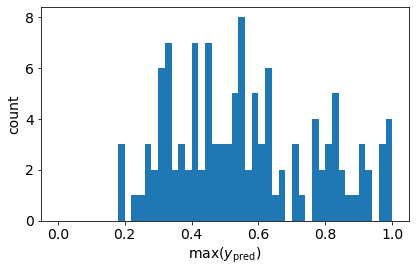

In [35]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)
ax.hist(ymax, bins=np.linspace(0,1,51))
ax.set(xlabel='$\max{(y_\mathrm{pred})}$',
       ylabel='count');
       #title='Tile {}, {}'.format(tile_id, obsdate));

### Selection on Classifier Output

To be conservative we can select only spectra where the classifier is very confident in its output, e.g., ymax > 0.99. See the [CNN training notebook](https://github.com/desihub/timedomain/blob/master/desitrip/docs/nb/cnn_multilabel-restframe.ipynb) for the motivation behind this cut.

In [50]:
idx = np.argwhere(ymax > 0.0) #0.99
labels = np.argmax(pred, axis=1)

In [51]:
idx.shape
label_names = ['Galaxy',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP',
          'KN']

### Save spectra and classification to file

In [52]:
# Save classification info to a table.
classification = Table()
classification['TARGETID'] = allfmap[idx]['TARGETID']
classification['CNNPRED'] = pred[idx]
classification['CNNLABEL'] = label_names_arr[labels[idx]]

# Merge the classification and redrock fit to the fibermap.
#Temporary fix for candidate mismatch
fmap = hstack([allfmap[idx], allzbest[idx], classification])
fmap['TARGETID_1'].name='TARGETID'
fmap.remove_columns(['TARGETID_2','TARGETID_3']) 

# Pack data into Spectra and write to FITS.
cand_spectra = Spectra(bands=['brz'],
                       wave={'brz' : allwave},
                       flux={'brz' : allflux[idx]},
                       ivar={'brz' : allivar[idx]},
                       mask={'brz' : allmask[idx]},
                       resolution_data={'brz' : allres[idx]},
                       fibermap=fmap
                   )

outfits = 'DECam_transient_spectra.fits'
write_spectra(outfits, cand_spectra)
print('Output file saved in {}'.format(outfits))


6


### GradCAM action happens here

Adapting from https://keras.io/examples/vision/grad_cam/

In [53]:
import tensorflow as tf
last_conv_layer_name = "conv1d_23"
classifier_layer_names = [
"batch_normalization_23",
"activation_23",
"max_pooling1d_23",
"flatten_5",
"dense_5",
"dropout_5",
"Output_Classes"
]

In [54]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        #print(layer_name,x.shape)
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    #print(grads.shape,pooled_grads.shape)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    #We apply ReLU here and select only elements>0
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

### Apply GradCAM to all spectra classified as transients


In [55]:
#allzbest = allzbest[1:] #TEMP
#allzbest.pprint_all()
#print(labels.shape)
#print(labels)
#print(rewave.shape)
#print(rsflux.shape)

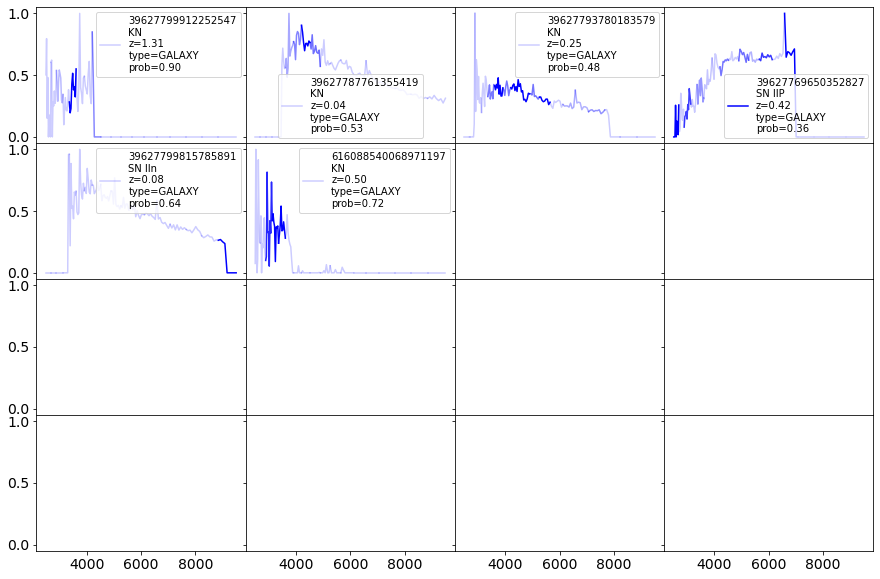

In [56]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

# Loop over all and create a bunch of 16x16 plots

fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection[:16], axes.flatten()):
    myarr=rsflux[j,:] 
    #print()

    # Print what the top predicted class is
    preds = classifier.predict(myarr)
    #print("Predicted:", preds)

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(
        myarr, classifier, last_conv_layer_name, classifier_layer_names
    )

    color='blue'
    rewave_nbin_inblock=rewave.shape[0]/float(heatmap.shape[0])
    first_bin=0
    for i in range(1,heatmap.shape[0]+1):
        alpha=np.min([1,heatmap[i-1]+0.2])
        last_bin=int(i*rewave_nbin_inblock)
        if (i==1):
            ax.plot(rewave[first_bin:last_bin+1], myarr[0,first_bin:last_bin+1],c=color,alpha=alpha,\
                    label = str(allzbest[j[0]]['TARGETID']) + "\n" +
                    label_names[labels[j[0]]] + 
                    '\nz={:.2f}'.format(allzbest[j[0]]['Z']) +
                    '\ntype={}'.format(allzbest[j[0]]['SPECTYPE']) +
                    '\nprob={:.2f}'.format(ymax[j[0]]))
        else:
            ax.plot(rewave[first_bin:last_bin+1], myarr[0,first_bin:last_bin+1],c=color,alpha=alpha)
        first_bin=last_bin
    ax.legend(fontsize=10)

### Plot spectra of objects classified as transients
Plot observed spectra

In [57]:
testwave, testflux, testivar = rebin_flux(allwave, allflux, allivar,
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)

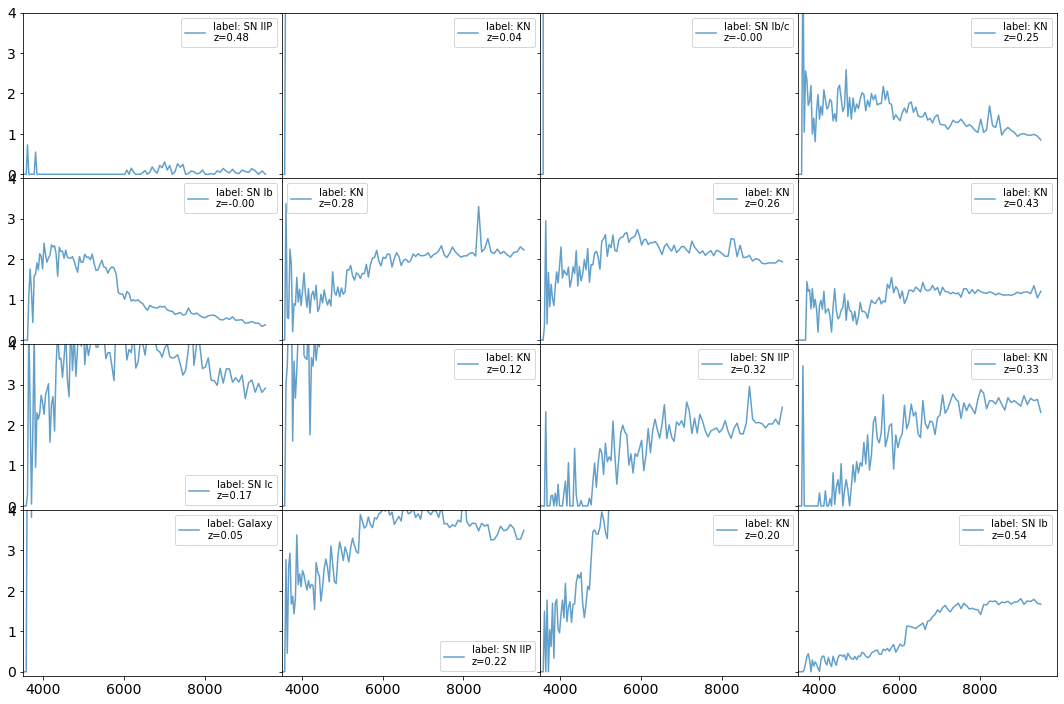

In [66]:
fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection, axes.flatten()):
    ax.plot(testwave, testflux[j[0]], alpha=0.7, label='label: '+label_names[labels[j[0]]] +# Just this for single plot with [0] on testflux, label_names, allzbest
            '\nz={:.2f}'.format(allzbest[j[0]]['Z'])) # +
            #'\nobsdate={}'.format(obsdates[j[0]]) +
            #'\ntile id: {}'.format(tile_ids[j[0]]) +
            #'\npetal id: {}'.format(petal_ids[j[0]]))
    
    ax.set(xlim=(3500,9900),ylim=(-0.1,4))
    #ax.fill_between([5600,6000],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    #ax.fill_between([7400,7800],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    ax.legend(fontsize=10)
    
#for k in [0,1,2]:
#    axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#    axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]', xlim=(3500,9900))
    
fig.tight_layout();
#filename = "spectra_plots/all_spectra_TAMU_ylim"
#plt.savefig(filename)

### For plotting individual plots

In [72]:
# Save to FITS files rather than PNG, see cnn_classify_data.py
# See line 404 - 430, 'Save Classification info to file'
#https://github.com/desihub/timedomain/blob/ab7257a4ed232875f5769cbb11c21f483ceccc5e/cronjobs/cnn_classify_data.py#L404

for j in selection:
    plt.plot(testwave, testflux[j[0]], alpha=0.7, label='label: '+ label_names[labels[j[0]]] + # Just this for single plot with [0] on testflux, label_names, allzbest
            #'\nz={:.2f}'.format(allzbest[j[0]]['Z']) +
            '\nprob={:.2f}'.format(ymax[j[0]]))
            #'\nobsdate={}'.format(obsdates[j[0]]) +
            #'\ntile id: {}'.format(tile_ids[j[0]]) +
            #'\npetal id: {}'.format(petal_ids[j[0]]))
    
    plt.xlim(3500, 9900)
    #plt.ylim(-0.1, 50)
    #ax.fill_between([5600,6000],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    #ax.fill_between([7400,7800],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    plt.legend(fontsize=10)
    filename = "spectra_plots/"+"_".join(("TAMU", "spectra", str(allzbest[j[0]]['TARGETID']), str(obsdates[j[0]]), str(tile_ids[j[0]]), str(petal_ids[j[0]]), label_names[labels[j[0]]].replace(" ", "-").replace("/","-")))
    #filename = "spectra_plots/"+"_".join(("TAMU", "spectra", str(obsdates[j[0]+1]), str(tile_ids[j[0]+1]), str(petal_ids[j[0]+1]), label_names[labels[j[0]]].replace(" ", "-"))) # temp
    #plt.show();
    #print(filename)
    plt.savefig(filename)
    plt.clf()
    
#for k in [0,1,2]:
#    axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#    axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]', xlim=(3500,9900))
    
#fig.tight_layout();
#filename = "spectra_plots/all_spectra_TAMU_ylim"
#filename = "_".join(("spectra", str(obsdate), str(tile_id), label_names[labels[0]].replace(" ", "-")))
#plt.savefig(filename)

<Figure size 432x288 with 0 Axes>

### Reading files in parallel

Does not work

In [ ]:
# Loop through zbest and coadd files for each petal.
# Extract the fibermaps, ZBEST tables, and spectra.
# Keep only BGS targets passing basic event selection.
allzbest = None
allfmap = None
allwave = None
allflux = None
allivar = None
allmask = None
allres  = None
handy_table = []

from joblib import Parallel, delayed

njobs=40
color_string = 'brz'

def get_spectra(cafile, zbfile,targetid,tamuid,obsdate,tileid): 
    # Access data per petal.
    print("Accessing file number ",count)
    print(cafile,zbfile)
    zbest = Table.read(zbfile, 'ZBEST')
    idx_zbest = (zbest['TARGETID']==targetid)
    targetids = zbest[idx_zbest]['TARGETID']
    chi2 = zbest[idx_zbest]['CHI2']
    
    pspectra = read_spectra(cafile)
    if obsdate>20210503:
        select_nite = pspectra.fibermap['NIGHT'] == obsdate
        pspectra = pspectra[select_nite]
    cspectra = coadd_cameras(pspectra)
    
    fibermap = cspectra.fibermap
    idx_fibermap = (fibermap['TARGETID'] == targetid)
    
    ra = fibermap[idx_fibermap]['TARGET_RA'][0]
    dec = fibermap[idx_fibermap]['TARGET_DEC'][0]
    
    return allzbest,allfmap, allwave, allflux, allivar, allmask, allres

    
allzbest,allfmap, allwave, allflux, allivar, allmask, allres = \
    Parallel(n_jobs=njobs)(delayed(get_spectra)(cafile, zbfile,targetid,tamuid,obsdate,tileid) \
    for cafile, zbfile,targetid,tamuid,obsdate,tileid in zip(cafiles, zbfiles, target_ids,tamuids, obsdates,tile_ids))    

